In [214]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import fitz

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from pprint import pprint

In [4]:
def list_files(directory, suffix='', recursive=True):

    if not directory.endswith(os.sep):
        directory = directory + os.sep

    files = []
    dir_files = os.listdir(directory)

    rec = recursive
    if type(recursive) is int:
        rec = recursive-1

    for f in dir_files:

        if f.lower().endswith(suffix):
            files.append(directory + f)

        elif ((recursive == True) | (recursive >= 1)) & os.path.isdir(directory + f):
            sub_dir_files = list_files(directory + f, suffix, rec)
            files = files + sub_dir_files

    return files

In [223]:
def flatten(t):
    return [item for sublist in t for item in sublist]

def merge_paper(paper):
    return ''.join(paper[:])

In [218]:
test_files_dir = "./test_files/"
test_files = list_files(test_files_dir)
test_files

['./test_files/LS_index_1937.pdf',
 './test_files/Argentinia_LS_index_1934_test_I_DE.pdf',
 './test_files/LS_index_1976.pdf',
 './test_files/LS_index_1944.pdf',
 './test_files/LS_index_1986.pdf',
 './test_files/LS_Index_1983.pdf',
 './test_files/LS_index_1944_split.pdf']

In [6]:
def read_pdf(path, print_info=True):

    pdf_pages = []
    pdf_dicts = []

    if print_info:
        print("Reading pdf from", path)
        print("...")

    with fitz.open(path) as pdf:
        for page in pdf:
            pdf_pages.append(page.get_text())
            
            pdf_dicts.append(page.get_text('dict', flags=~fitz.TEXT_PRESERVE_IMAGES))

    if print_info:
        print("Finished reading", len(pdf_pages), "page(s)")

    return pdf_pages, pdf_dicts

In [222]:
pages, dicts = read_pdf(test_files[6])

Reading pdf from ./test_files/LS_index_1944_split.pdf
...
Finished reading 6 page(s)


In [146]:
page_b = dicts[3]["blocks"]
page_lines = []
lines_bbox = []

for b in page_b:
    for l in b["lines"]:
        line = []
        bbox = l["bbox"]
        for s in l["spans"]:
            line.append(s["text"])
        
        page_lines.append(line)
        lines_bbox.append(bbox)

In [153]:
d = 2
lines_df = pd.DataFrame({
    "line_text": page_lines, 
    "x0": [round(b[0], d) for b in lines_bbox],
    "y0": [round(b[1], d) for b in lines_bbox],
    "x1": [round(b[2], d) for b in lines_bbox],
    "y1": [round(b[3], d) for b in lines_bbox],
})

lines_df = lines_df.drop(40)
lines_df.head(30)

,line_text,x0,y0,x1,y1
0,[1944—Indexes I],47.0,48.06,103.22,56.46
1,[—],194.0,49.11,202.20,57.31
2,[4],206.0,50.25,209.61,56.75
3,[—],214.0,49.34,221.90,57.24
4,[Queensland],49.0,66.06,102.92,76.06
5,[Dec. 1],58.0,83.61,82.53,93.01
6,[An Act to suspend certain provisions of the U...,105.0,82.71,364.39,92.51
7,"[Insurance Acts, 1922 to 19368, and for purpos...",105.0,90.69,365.77,100.39
8,"[8 Geo. VI, No. 14.]",105.0,98.64,184.64,109.34
9,[The Unemployed Workers Insurance Acts],195.0,98.59,365.53,108.69


In [154]:
lines_df["dy"] = lines_df["y0"].diff(periods=1).abs()
lines_df["line_no"] = lines_df["dy"].gt(4).cumsum()

lines_df.head(50)

,line_text,x0,y0,x1,y1,dy,line_no
0,[1944—Indexes I],47.0,48.06,103.22,56.46,NaN,0
1,[—],194.0,49.11,202.20,57.31,1.05,0
2,[4],206.0,50.25,209.61,56.75,1.14,0
3,[—],214.0,49.34,221.90,57.24,0.91,0
4,[Queensland],49.0,66.06,102.92,76.06,16.72,1
5,[Dec. 1],58.0,83.61,82.53,93.01,17.55,2
6,[An Act to suspend certain provisions of the U...,105.0,82.71,364.39,92.51,0.90,2
7,"[Insurance Acts, 1922 to 19368, and for purpos...",105.0,90.69,365.77,100.39,7.98,3
8,"[8 Geo. VI, No. 14.]",105.0,98.64,184.64,109.34,7.95,4
9,[The Unemployed Workers Insurance Acts],195.0,98.59,365.53,108.69,0.05,4


In [286]:
lines = []
line_spans = []
x0 = []
y0 = []
x1 = []
y1 = []

for l in lines_df.groupby("line_no"):
    line = []
    for r in l[1].iterrows():
        line.append(r[1]["line_text"])
        
    lines.append(" ".join(flatten(line)))
    line_spans.append(flatten(line))
    
    x0.append(l[1]["x0"].min())
    y0.append(l[1]["y0"].min())
    x1.append(l[1]["x1"].max())
    y1.append(l[1]["y1"].max()) 

blines_df = pd.DataFrame({
    "line_text": lines,
    "spans": line_spans,
    "x0": x0,
    "y0": y0,
    "x1": x1,
    "y1": y1,
})

blines_df

,line_text,spans,x0,y0,x1,y1
0,1944—Indexes I — 4 —,"[1944—Indexes I, —, 4, —]",47.0,48.06,221.90,57.31
1,Queensland,[Queensland],49.0,66.06,102.92,76.06
2,Dec. 1 An Act to suspend certain provisions of...,"[Dec. 1, An Act to suspend certain provisions ...",58.0,82.71,364.39,93.01
3,"Insurance Acts, 1922 to 19368, and for purpose...","[Insurance Acts, 1922 to 19368, and for purpos...",105.0,90.69,365.77,100.39
4,"8 Geo. VI, No. 14. The Unemployed Workers Insu...","[8 Geo. VI, No. 14., The Unemployed Workers In...",105.0,98.59,365.53,109.34
5,Amendment Act of 1944.,[Amendment Act of 1944.],105.0,107.51,201.08,116.91
6,Dec. 14 An Act to amend the Workers' Compensat...,"[Dec. 14, An Act to amend the Workers' Compens...",58.0,121.11,364.94,131.34
7,in certain particulars [compensation for certa...,[in certain particulars [compensation for cert...,105.0,129.24,364.62,138.74
8,for hospital and medical treatmenti. 9 Geo. VI...,"[for hospital and medical treatmenti., 9 Geo. ...",105.0,135.74,365.15,147.34
9,Workers' Compensation Acts Amendment Act of 194&,[Workers' Compensation Acts Amendment Act of 1...,106.0,145.19,321.66,154.89


In [287]:
X = blines_df[["x0","x1"]].to_numpy()
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X0 = blines_df["x0"].to_numpy()
X0 = [[e] for e in X0]

kmeans0 = KMeans(n_clusters=3).fit(X0)
kmeans0.labels_

X1 = blines_df["x1"].to_numpy()
X1 = [[e] for e in X1]

kmeans1 = KMeans(n_clusters=3).fit(X1)
kmeans1.labels_

array([2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [288]:
blines_df["labels_kmeans_0"] = kmeans0.labels_
blines_df["labels_kmeans_1"] = kmeans1.labels_
blines_df

,line_text,spans,x0,y0,x1,y1,labels_kmeans_0,labels_kmeans_1
0,1944—Indexes I — 4 —,"[1944—Indexes I, —, 4, —]",47.0,48.06,221.90,57.31,1,2
1,Queensland,[Queensland],49.0,66.06,102.92,76.06,1,1
2,Dec. 1 An Act to suspend certain provisions of...,"[Dec. 1, An Act to suspend certain provisions ...",58.0,82.71,364.39,93.01,2,0
3,"Insurance Acts, 1922 to 19368, and for purpose...","[Insurance Acts, 1922 to 19368, and for purpos...",105.0,90.69,365.77,100.39,0,0
4,"8 Geo. VI, No. 14. The Unemployed Workers Insu...","[8 Geo. VI, No. 14., The Unemployed Workers In...",105.0,98.59,365.53,109.34,0,0
5,Amendment Act of 1944.,[Amendment Act of 1944.],105.0,107.51,201.08,116.91,0,2
6,Dec. 14 An Act to amend the Workers' Compensat...,"[Dec. 14, An Act to amend the Workers' Compens...",58.0,121.11,364.94,131.34,2,0
7,in certain particulars [compensation for certa...,[in certain particulars [compensation for cert...,105.0,129.24,364.62,138.74,0,0
8,for hospital and medical treatmenti. 9 Geo. VI...,"[for hospital and medical treatmenti., 9 Geo. ...",105.0,135.74,365.15,147.34,0,0
9,Workers' Compensation Acts Amendment Act of 194&,[Workers' Compensation Acts Amendment Act of 1...,106.0,145.19,321.66,154.89,0,0


<AxesSubplot:xlabel='labels_kmeans_0', ylabel='x0'>

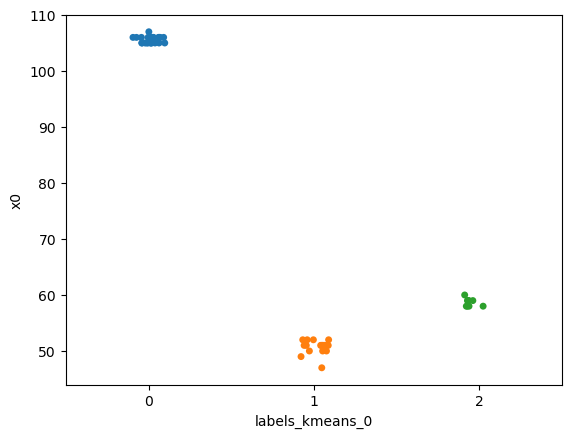

In [290]:
sns.stripplot(data=blines_df, y = "x0", x = "labels_kmeans_0")

<AxesSubplot:xlabel='labels_kmeans_1', ylabel='x1'>

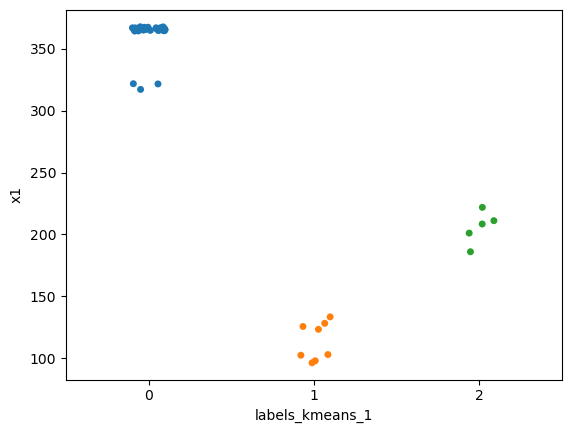

In [291]:
sns.stripplot(data=blines_df, y = "x1", x = "labels_kmeans_1")

In [231]:
sns.scatterplot(data=blines_df[["x0", "labels_kmeans"]], x = "x0", y = "x1", hue="labels_kmeans")

ValueError: Could not interpret value `x1` for parameter `y`

In [16]:
dicts[3]["blocks"]

[{'number': 0,
  'type': 0,
  'bbox': (47.0, 48.0600471496582, 221.89999389648438, 57.31000900268555),
  'lines': [{'spans': [{'size': 8.399999618530273,
      'flags': 4,
      'font': 'Times-Roman',
      'color': 0,
      'ascender': 0.75,
      'descender': -0.25,
      'text': '1944—Indexes I',
      'origin': (47.0, 54.36004638671875),
      'bbox': (47.0,
       48.0600471496582,
       103.22126007080078,
       56.460044860839844)}],
    'wmode': 0,
    'dir': (1.0, 0.0),
    'bbox': (47.0, 48.0600471496582, 103.22126007080078, 56.460044860839844)},
   {'spans': [{'size': 8.199999809265137,
      'flags': 4,
      'font': 'Times-Roman',
      'color': 0,
      'ascender': 0.75,
      'descender': -0.25,
      'text': '—',
      'origin': (194.0, 55.260009765625),
      'bbox': (194.0,
       49.110008239746094,
       202.1999969482422,
       57.31000900268555)}],
    'wmode': 0,
    'dir': (1.0, 0.0),
    'bbox': (194.0, 49.110008239746094, 202.1999969482422, 57.310009002685

In [15]:
print(pages[3])

1944—Indexes I
— 4 —
Queensland
Dec. 1
An Act to suspend certain provisions of the Unemployed Workers
Insurance Acts, 1922 to 19368, and for purposes incidental thereto.
8 Geo. VI, No. 14.
The Unemployed Workers Insurance Acts
Amendment Act of 1944.
Dec. 14
An Act to amend the Workers' Compensation Acts, 1916 to 1943',
in certain particulars [compensation for certain diseases and liability
for hospital and medical treatmenti.
9 Geo. VI, No. 2.
The
Workers' Compensation Acts Amendment Act of 194&
Dec. 14
An Act to provide that persons who, during war, have been
members of fighting forces shall receive preference in employment,
and to amend The Industrial Conciliation and Arbitration Acts,
1932 to
194210, in certain particulars.
9 Geo. VI, No. 4.
The
Industrial Conciliation and Arbitration Acts (War Preference in
Employment) Act of 1944.
South Australia
Dec. 14
An Act to amend the Workmen's Compensation Act,
No. 33 of 1944.
Workmen's Compensation Act Amendment Act,
1944.
Tasmania
Apr. 27

## Probleme
- Dokumente mit 2 Spalten
- Dokumente mit Länder-Überschrift über ganze Breite der Seite

## Fragen
- Sollen Regionen auch rausgefiltert werden?
- Sollen zusätzliche Infos in Klammern auch rausgefiltert werden?